In [1]:
from __future__ import print_function

import torch
from pyDOE import lhs
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

np.random.seed(1234)

In [2]:
print("Cuda availability: ", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Cuda availability:  True
NVIDIA RTX A6000


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),

            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),

            nn.Linear(20, 2))                    
        
    def forward(self, x):
        return self.net(x)

In [4]:
def function(self, x, y):
    nu = 1 / 1000   # Re = 100

    res = self.net(torch.hstack((x, y)))
    psi, p = res[:, 0:1], res[:, 1:2]    # NN output: velocity field and pressure field 

    u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0].to(device)
    v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0].to(device)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0].to(device)
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0].to(device)
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0].to(device)
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0].to(device)

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0].to(device)
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0].to(device)
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0].to(device)
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0].to(device)

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0].to(device)
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0].to(device)

    f = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    g = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    return u, v, p, f, g

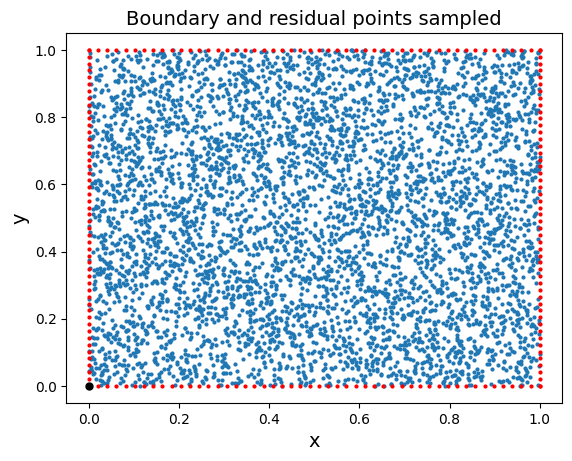

In [5]:
######### Origin ##########
x_origin = np.array([[0.]])
y_origin = np.array([[0.]])
x_origin_in = Variable(torch.from_numpy(np.reshape(x_origin, (-1, 1))).float(), requires_grad = True).to(device)
y_origin_in = Variable(torch.from_numpy(np.reshape(y_origin, (-1, 1))).float(), requires_grad = True).to(device) 


##### Boundary points #####
boundary_num = 50

# upper boundary
x_up = np.linspace(0., 1., boundary_num)
y_up = np.ones(boundary_num)
x_up_in = Variable(torch.from_numpy(np.reshape(x_up, (-1, 1))).float(), requires_grad = True).to(device)
y_up_in = Variable(torch.from_numpy(np.reshape(y_up, (-1, 1))).float(), requires_grad = True).to(device)   

# lower boundary
x_low = np.linspace(0., 1., boundary_num)
y_low = np.zeros(boundary_num)
x_low_in = Variable(torch.from_numpy(np.reshape(x_low, (-1, 1))).float(), requires_grad = True).to(device)
y_low_in = Variable(torch.from_numpy(np.reshape(y_low, (-1, 1))).float(), requires_grad = True).to(device)      

# left boundary
x_left = np.zeros(boundary_num)
y_left = np.linspace(0., 1., boundary_num)
x_left_in = Variable(torch.from_numpy(np.reshape(x_left, (-1, 1))).float(), requires_grad = True).to(device)
y_left_in = Variable(torch.from_numpy(np.reshape(y_left, (-1, 1))).float(), requires_grad = True).to(device)   

# right boundary
x_right = np.ones(boundary_num) 
y_right = np.linspace(0., 1., boundary_num)
x_right_in = Variable(torch.from_numpy(np.reshape(x_right, (-1, 1))).float(), requires_grad = True).to(device)
y_right_in = Variable(torch.from_numpy(np.reshape(y_right, (-1, 1))).float(), requires_grad = True).to(device)  


##### Residual points #####
res_num = 5000
res_pts = lhs(2, res_num)

x_res = res_pts[:, 0]
y_res = res_pts[:, 1]
x_res_in = Variable(torch.from_numpy(np.reshape(x_res, (-1, 1))).float(), requires_grad = True).to(device)
y_res_in = Variable(torch.from_numpy(np.reshape(y_res, (-1, 1))).float(), requires_grad = True).to(device)


######### Plotting ########
plt.plot(x_res, y_res, "o", markersize=2)
plt.plot(x_up, y_up, "ro", markersize=2)
plt.plot(x_left, y_left, "ro", markersize=2)
plt.plot(x_right, y_right, "ro", markersize=2)
plt.plot(x_low, y_low, "ro", markersize=2)
plt.plot(x_origin, y_origin, "ko", markersize=5)

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Boundary and residual points sampled", fontsize=14)
plt.show()

In [6]:
net = Net()
print(net)
net = net.to(device)

##### Xavier Initialization #####
for m in net.modules():
    if isinstance(m, (nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)


##### Loss Function #####
mse_loss_func = torch.nn.MSELoss()
optimizer_adam = torch.optim.Adam(net.parameters(), lr=0.001)
loss_Adam = []

optimizer_LBFGS = torch.optim.LBFGS(net.parameters(), history_size=8, max_iter=500000)
loss_LBFGS = []


######### Training ########

#### Adam ####
N_iter_Adam = 10001
print("------ IN Adam ------")
for n in range(N_iter_Adam):
    def closure():
        optimizer_adam.zero_grad()
        
        ##### Origin #####
        u_origin, v_origin, p_origin, f_origin, g_origin = function(net, x_origin_in, y_origin_in)
        zero = torch.zeros(1, 1).to(device)
        loss_origin = mse_loss_func(p_origin, zero)     # pressure is 0 at origin

        ##### Boundary #####
        boundary_num = x_up_in.shape[0]
        zeros = torch.zeros(boundary_num, 1).to(device)
        ones = torch.ones(boundary_num, 1).to(device)

        # upper boundary 
        u_up, v_up, p_up, f_up, g_up = function(net, x_up_in, y_up_in)
        u_loss_up = mse_loss_func(u_up, ones)           # u = 1 at upper boundary 
        v_loss_up = mse_loss_func(v_up, zeros)          # v = 0 at upper boundary 
        loss_up = u_loss_up + v_loss_up

        # lower boundary 
        u_low, v_low, p_low, f_low, g_low = function(net, x_low_in, y_low_in)
        u_loss_low = mse_loss_func(u_low, zeros)        # u = 0 at lower boundary 
        v_loss_low = mse_loss_func(v_low, zeros)        # v = 0 at lower boundary 
        loss_low = u_loss_low + v_loss_low

        # left boundary 
        u_left, v_left, p_left, f_left, g_left = function(net, x_left_in, y_left_in)
        u_loss_left = mse_loss_func(u_left, zeros)      # u = 0 at lower boundary
        v_loss_left = mse_loss_func(v_left, zeros)      # v = 0 at lower boundary
        loss_left = u_loss_left + v_loss_left

        # right boundary 
        u_right, v_right, p_right, f_right, g_right = function(net, x_right_in, y_right_in)
        u_loss_right = mse_loss_func(u_right, zeros)        # u = 0 at lower boundary
        v_loss_right = mse_loss_func(v_right, zeros)        # v = 0 at lower boundary
        loss_right = u_loss_right + v_loss_right

        ##### Residual #####
        res_num = x_res_in.shape[0]
        zeros1 = torch.zeros(res_num, 1).to(device)

        u_res, v_res, p_res, f_res, g_res = function(net, x_res_in, y_res_in)
        f_loss_res = mse_loss_func(f_res, zeros1)       # to satisfy the PDE
        g_loss_res = mse_loss_func(g_res, zeros1)       # to satisfy the PDE
        loss_res = f_loss_res + g_loss_res

        # LOSS FUNCTION:
        loss = loss_origin + loss_up + loss_low + loss_left + loss_right + loss_res 
        loss.backward()
        return loss
       
    optimizer_adam.step(closure)
    loss = closure() 
    loss_Adam.append(loss.cpu().detach().numpy())
    
    if n%100 == 0:
        print("Adam - Epoch: ", n, "Training Loss: ", loss.item())


#### LBFGS ####
N_iter_LBFGS = 20
print("------ IN LBFGS ------")
for n in range(N_iter_LBFGS):
    def closure():
        optimizer_LBFGS.zero_grad()
        
        ##### Origin #####
        u_origin, v_origin, p_origin, f_origin, g_origin = function(net, x_origin_in, y_origin_in)
        zero = torch.zeros(1, 1).to(device)
        loss_origin = mse_loss_func(p_origin, zero)     # pressure is 0 at origin

        ##### Boundary #####
        boundary_num = x_up_in.shape[0]
        zeros = torch.zeros(boundary_num, 1).to(device)
        ones = torch.ones(boundary_num, 1).to(device)

        # upper boundary 
        u_up, v_up, p_up, f_up, g_up = function(net, x_up_in, y_up_in)
        u_loss_up = mse_loss_func(u_up, ones)           # u = 1 at upper boundary 
        v_loss_up = mse_loss_func(v_up, zeros)          # v = 0 at upper boundary 
        loss_up = u_loss_up + v_loss_up

        # lower boundary 
        u_low, v_low, p_low, f_low, g_low = function(net, x_low_in, y_low_in)
        u_loss_low = mse_loss_func(u_low, zeros)        # u = 0 at lower boundary 
        v_loss_low = mse_loss_func(v_low, zeros)        # v = 0 at lower boundary 
        loss_low = u_loss_low + v_loss_low

        # left boundary 
        u_left, v_left, p_left, f_left, g_left = function(net, x_left_in, y_left_in)
        u_loss_left = mse_loss_func(u_left, zeros)      # u = 0 at lower boundary
        v_loss_left = mse_loss_func(v_left, zeros)      # v = 0 at lower boundary
        loss_left = u_loss_left + v_loss_left

        # right boundary 
        u_right, v_right, p_right, f_right, g_right = function(net, x_right_in, y_right_in)
        u_loss_right = mse_loss_func(u_right, zeros)        # u = 0 at lower boundary
        v_loss_right = mse_loss_func(v_right, zeros)        # v = 0 at lower boundary
        loss_right = u_loss_right + v_loss_right

        ##### Residual #####
        res_num = x_res_in.shape[0]
        zeros1 = torch.zeros(res_num, 1).to(device)

        u_res, v_res, p_res, f_res, g_res = function(net, x_res_in, y_res_in)
        f_loss_res = mse_loss_func(f_res, zeros1)       # to satisfy the PDE
        g_loss_res = mse_loss_func(g_res, zeros1)       # to satisfy the PDE
        loss_res = f_loss_res + g_loss_res

        # LOSS FUNCTION:
        loss = loss_origin + loss_up + loss_low + loss_left + loss_right + loss_res 
        loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure() 
    loss_LBFGS.append(loss.cpu().detach().numpy())
    
    print("LBFGS - Epoch: ", n, "Training Loss: ", loss.item())

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=2, bias=True)
  )
)
------ IN Adam ------
Adam - Epoch:  0 Training Loss:  1.6411446332931519
Adam - Epoch:  100 Training Loss:  0.09781099855899811
Adam - Epoch:  200 Training Loss:  0.05847291275858879
Adam - Epoch:  300 Training Loss:  0.06659039855003357
Adam - Epoch:  400 Training Loss:  0.04621130973100662
Adam - Epoch:  500 Training Loss:  0.04506475478410721
Adam - Epoch:  600 Train

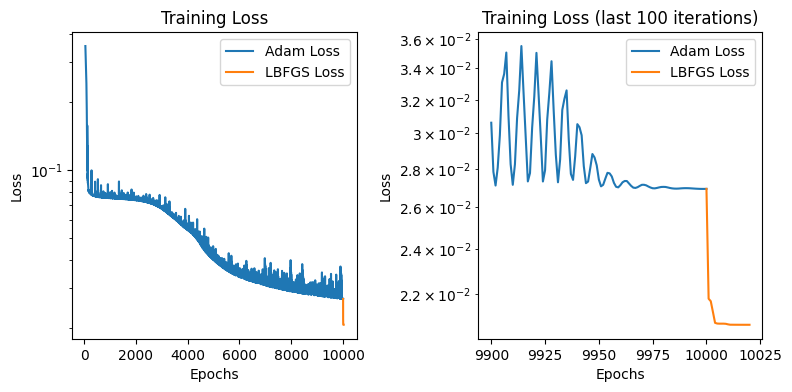

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

ep1 = np.arange(50, N_iter_Adam)
ep2 = np.arange(N_iter_Adam - 1, N_iter_Adam + N_iter_LBFGS)

loss_LBFGS1 = [loss_Adam[-1]] + loss_LBFGS
axs[0].semilogy(ep1, loss_Adam[50:], label="Adam Loss")
axs[0].semilogy(ep2, loss_LBFGS1, label="LBFGS Loss")
axs[0].legend()
axs[0].set_title('Training Loss' )
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

ep3 = np.arange(9900, N_iter_Adam)
ep4 = np.arange(N_iter_Adam - 1, N_iter_Adam + N_iter_LBFGS)
axs[1].semilogy(ep3, loss_Adam[9900:], label="Adam Loss")
axs[1].semilogy(ep4, loss_LBFGS1, label="LBFGS Loss")
axs[1].legend()
axs[1].set_title('Training Loss (last 100 iterations)' )
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

fig.tight_layout(pad=1.0)
plt.show()
plt.savefig("Loss.png")

In [ ]:
def find_uvp(X, Y, N_plt):
    XX = Variable(torch.from_numpy(X.reshape(-1,1)).float(), requires_grad = True).to(device)
    YY = Variable(torch.from_numpy(Y.reshape(-1,1)).float(), requires_grad = True).to(device)
    uu, vv, pp, ff, gg = function(net, XX, YY)
    u = uu.cpu().detach().numpy().reshape(-N_plt,N_plt)
    v = vv.cpu().detach().numpy().reshape(-N_plt,N_plt)
    p = pp.cpu().detach().numpy().reshape(-N_plt,N_plt)
    return u, v, p

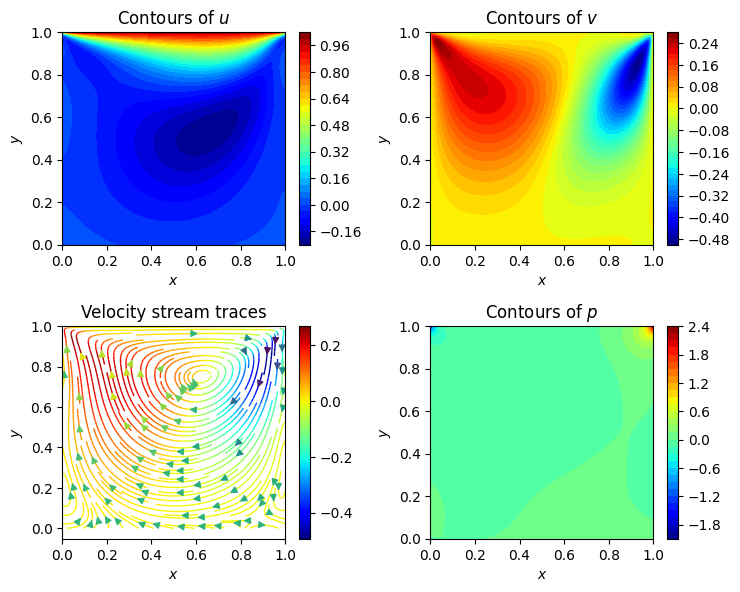

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6), sharey=False)
N_plt = 200

xlist = np.linspace(0., 1., N_plt)
ylist = np.linspace(0., 1., N_plt)
X, Y = np.meshgrid(xlist, ylist)
u, v, p = find_uvp(X, Y, N_plt)

N_resolution = 40
### Plot u ###
cp_u = axs[0, 0].contourf(X, Y, u, N_resolution)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
axs[0, 0].set_title('Contours of $u$')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$y$')

### Plot v ###
cp_v = axs[0, 1].contourf(X, Y, v, N_resolution)
fig.colorbar(cp_v) 
cp_v.set_cmap('jet')
axs[0, 1].set_title('Contours of $v$')
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$y$')

### Plot velocity field ###
strm = axs[1, 0].streamplot(X, Y, u, v, color=v, density=1.5, linewidth=1)
fig.colorbar(strm.lines)
strm.lines.set_cmap('jet')
axs[1, 0].set_title('Velocity stream traces' )
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$y$')

### Plot p ###
cp_p = axs[1, 1].contourf(X, Y, p, N_resolution)
fig.colorbar(cp_p) 
cp_p.set_cmap('jet')
axs[1, 1].set_title('Contours of $p$')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$y$')

fig.tight_layout(pad=1.0)
plt.show()
plt.savefig("Results.png")
